In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
tf.__version__

'1.14.0'

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

## load data for all

In [3]:
# df = pd.read_csv('concat_filtered_df_timeperiod_49.csv')
# description = df.description.unique().tolist()

## load data for buffer 1,2,3

In [4]:
#load data csv
buffer_1 = pd.read_csv('df_by_description_Buf_4.csv')
buffer_2 = pd.read_csv('df_by_description_Buf_5.csv')
buffer_3 = pd.read_csv('df_by_description_Buf_6.csv')

In [5]:
# combine buffer_1, buffer_2, buffer_3 into one df and explore their connections
buffer = pd.DataFrame(columns = ['date', 'buffer_1', 'buffer_2', 'buffer_3'])
buffer['date'] = buffer_1['date']
buffer['buffer_1']=buffer_1['quantity']
buffer['buffer_2']=buffer_2['quantity']
buffer['buffer_3']=buffer_3['quantity']
buffer['date'] =  pd.to_datetime(buffer['date'])

<Figure size 432x288 with 0 Axes>

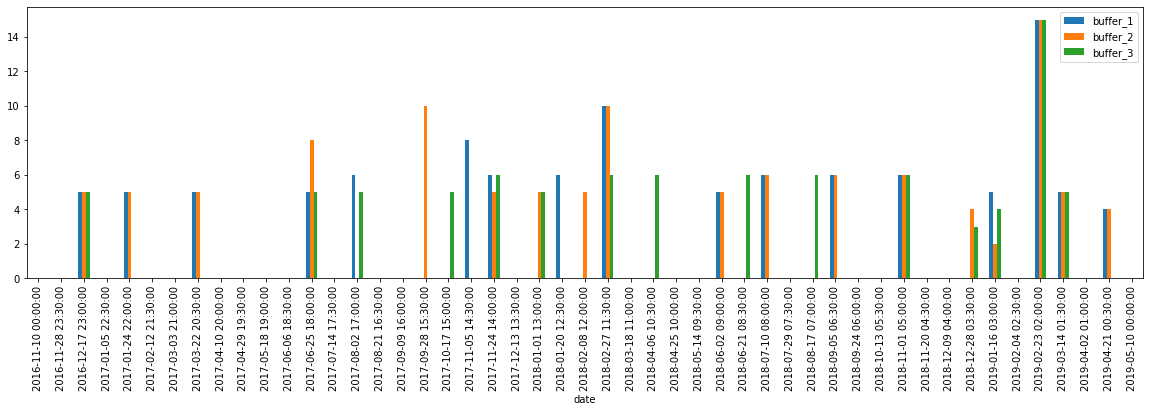

In [6]:
plt.figure()
buffer.plot.bar(x='date', y=['buffer_1', 'buffer_2', 'buffer_3'], figsize=(20,5))

In [7]:
corr = buffer.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,buffer_1,buffer_2,buffer_3
buffer_1,1,0.72,0.57
buffer_2,0.72,1,0.56
buffer_3,0.57,0.56,1


## train test split

In [8]:
training_set = buffer.iloc[:42].values
test_set = buffer.iloc[42:].values
total_set = buffer.iloc[::].values

np.shape(test_set)

(7, 4)

## benchmark_1
## by random guessing a number between 0 and max

In [11]:
# consider buffer_1
real_y_buffer_1 = buffer_1.iloc[42:,1].values

# find the range of the training_set
max_train_buffer_1 = buffer_1['quantity'].max()

# generate random numbers
from random import randrange
dummys_y = []
for j in range(1000):
    dummy_y = []
    for i in range(7):
        dummy_y.append(randrange(max_train_buffer_1))
    dummys_y.append(dummy_y)


from sklearn.metrics import mean_absolute_error
a = []
for i in dummys_y:
    a.append(mean_absolute_error(real_y_buffer_1, i))
print(sum(a)/1000)

5.882000000000004


## benchmark_2
## by taking the average of training set

In [12]:
# consider buffer_1

# find the mean
mean_train_buffer_1 = buffer_1['quantity'].mean() # = 2.204081632653061
b_1 = [mean_train_buffer_1]*7
print('buffer_1: ', mean_absolute_error(real_y_buffer_1, b_1))

# consider buffer_2

# find the range of the training_set
real_y_buffer_2 = buffer_2.iloc[42:,1].values
mean_train_buffer_2 = buffer_2['quantity'].mean() 
b_2 = [mean_train_buffer_2]*7
print('buffer_2: ', mean_absolute_error(real_y_buffer_2, b_2))

# consider buffer_3

# find the range of the training_set
real_y_buffer_3 = buffer_3.iloc[42:,1].values
mean_train_buffer_3 = buffer_3['quantity'].mean() 
b_3 = [mean_train_buffer_3]*7
print('buffer_3: ', mean_absolute_error(real_y_buffer_3, b_3))


buffer_1:  3.82798833819242
buffer_2:  3.4664723032069973
buffer_3:  3.685131195335277


## rolling window of width 5

In [13]:
# set parameters
rolling_window = 5
my_epochs = 2000
my_batch_size = 32
my_units = 50
my_dropout = 0.2

In [14]:
# Creating a data structure with rolling_window timesteps and 1 output
X_train_buffer_1 = []
y_train_buffer_1 = []
for i in range(rolling_window, 42):
    X_train_buffer_1.append(training_set[i-rolling_window:i, 1])
    y_train_buffer_1.append(training_set[i, 1])
X_train_buffer_1, y_train_buffer_1 = np.array(X_train_buffer_1), np.array(y_train_buffer_1)

# Reshaping
X_train_buffer_1 = np.reshape(X_train_buffer_1, (X_train_buffer_1.shape[0], X_train_buffer_1.shape[1], 1))

## building LSTM

In [15]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [16]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = my_units, return_sequences = True, input_shape = (X_train_buffer_1.shape[1], 1)))
regressor.add(Dropout(my_dropout))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = my_units, return_sequences = True))
regressor.add(Dropout(my_dropout))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = my_units))
regressor.add(Dropout(my_dropout))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics=['accuracy', 'mae'])

# Fitting the RNN to the Training set
regressor.fit(X_train_buffer_1, y_train_buffer_1, epochs = my_epochs, batch_size = my_batch_size)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/2000
37/37 [==============================] - 2s 46ms/step - loss: 1.8714 - acc: 0.7027 - mean_absolute_error: 1.8714
Epoch 2/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8718 - acc: 0.7027 - mean_absolute_error: 1.8718
Epoch 3/2000
37/37 [==============================] - 0s 592us/step - loss: 1.8750 - acc: 0.7027 - mean_absolute_error: 1.8750
Epoch 4/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8717 - acc: 0.7027 - mean_absolute_error: 1.8717
Epoch 5/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8720 - acc: 0.7027 - mean_absolute_error: 1.8720
Epoch 6/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8722 - acc: 0.7027 - mean_absolute_error: 1.8722
Epoch 7/2000
37/37 [====

37/37 [==============================] - 0s 566us/step - loss: 1.8670 - acc: 0.7027 - mean_absolute_error: 1.8670
Epoch 115/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8672 - acc: 0.7027 - mean_absolute_error: 1.8672
Epoch 116/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8667 - acc: 0.7027 - mean_absolute_error: 1.8667
Epoch 117/2000
37/37 [==============================] - 0s 728us/step - loss: 1.8658 - acc: 0.7027 - mean_absolute_error: 1.8658
Epoch 118/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8664 - acc: 0.7027 - mean_absolute_error: 1.8664
Epoch 119/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8661 - acc: 0.7027 - mean_absolute_error: 1.8661
Epoch 120/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8668 - acc: 0.7027 - mean_absolute_error: 1.8668
Epoch 121/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8666 - acc: 0.7027 - mean_absolu

37/37 [==============================] - 0s 593us/step - loss: 1.8666 - acc: 0.7027 - mean_absolute_error: 1.8666
Epoch 178/2000
37/37 [==============================] - 0s 539us/step - loss: 1.8663 - acc: 0.7027 - mean_absolute_error: 1.8663
Epoch 179/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8657 - acc: 0.7027 - mean_absolute_error: 1.8657
Epoch 180/2000
37/37 [==============================] - 0s 647us/step - loss: 1.8671 - acc: 0.7027 - mean_absolute_error: 1.8671
Epoch 181/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8673 - acc: 0.7027 - mean_absolute_error: 1.8673
Epoch 182/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8681 - acc: 0.7027 - mean_absolute_error: 1.8681
Epoch 183/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8660 - acc: 0.7027 - mean_absolute_error: 1.8660
Epoch 184/2000
37/37 [==============================] - 0s 620us/step - loss: 1.8659 - acc: 0.7027 - mean_absolu

37/37 [==============================] - 0s 566us/step - loss: 1.8653 - acc: 0.7027 - mean_absolute_error: 1.8653
Epoch 304/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8657 - acc: 0.7027 - mean_absolute_error: 1.8657
Epoch 305/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8658 - acc: 0.7027 - mean_absolute_error: 1.8658
Epoch 306/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8656 - acc: 0.7027 - mean_absolute_error: 1.8656
Epoch 307/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8656 - acc: 0.7027 - mean_absolute_error: 1.8656
Epoch 308/2000
37/37 [==============================] - 0s 539us/step - loss: 1.8657 - acc: 0.7027 - mean_absolute_error: 1.8657
Epoch 309/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8662 - acc: 0.7027 - mean_absolute_error: 1.8662
Epoch 310/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8653 - acc: 0.7027 - mean_absolu

37/37 [==============================] - 0s 620us/step - loss: 1.8652 - acc: 0.7027 - mean_absolute_error: 1.8652
Epoch 430/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8656 - acc: 0.7027 - mean_absolute_error: 1.8656
Epoch 431/2000
37/37 [==============================] - 0s 620us/step - loss: 1.8656 - acc: 0.7027 - mean_absolute_error: 1.8656
Epoch 432/2000
37/37 [==============================] - 0s 674us/step - loss: 1.8657 - acc: 0.7027 - mean_absolute_error: 1.8657
Epoch 433/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8649 - acc: 0.7027 - mean_absolute_error: 1.8649
Epoch 434/2000
37/37 [==============================] - 0s 566us/step - loss: 1.8657 - acc: 0.7027 - mean_absolute_error: 1.8657
Epoch 435/2000
37/37 [==============================] - 0s 674us/step - loss: 1.8655 - acc: 0.7027 - mean_absolute_error: 1.8655
Epoch 436/2000
37/37 [==============================] - 0s 593us/step - loss: 1.8660 - acc: 0.7027 - mean_absolu

37/37 [==============================] - 0s 809us/step - loss: 1.8651 - acc: 0.7027 - mean_absolute_error: 1.8651
Epoch 556/2000
37/37 [==============================] - 0s 863us/step - loss: 1.8659 - acc: 0.7027 - mean_absolute_error: 1.8659
Epoch 557/2000
37/37 [==============================] - 0s 863us/step - loss: 1.8652 - acc: 0.7027 - mean_absolute_error: 1.8652
Epoch 558/2000
37/37 [==============================] - 0s 970us/step - loss: 1.8651 - acc: 0.7027 - mean_absolute_error: 1.8651
Epoch 559/2000
37/37 [==============================] - 0s 728us/step - loss: 1.8652 - acc: 0.7027 - mean_absolute_error: 1.8652
Epoch 560/2000
37/37 [==============================] - 0s 782us/step - loss: 1.8659 - acc: 0.7027 - mean_absolute_error: 1.8659
Epoch 561/2000
37/37 [==============================] - 0s 755us/step - loss: 1.8651 - acc: 0.7027 - mean_absolute_error: 1.8651
Epoch 562/2000
37/37 [==============================] - 0s 755us/step - loss: 1.8653 - acc: 0.7027 - mean_absolu

37/37 [==============================] - 0s 1ms/step - loss: 1.7354 - acc: 0.7027 - mean_absolute_error: 1.7354
Epoch 682/2000
37/37 [==============================] - 0s 943us/step - loss: 1.5070 - acc: 0.7297 - mean_absolute_error: 1.5070
Epoch 683/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.5037 - acc: 0.7297 - mean_absolute_error: 1.5037
Epoch 684/2000
37/37 [==============================] - 0s 943us/step - loss: 1.5271 - acc: 0.7297 - mean_absolute_error: 1.5271
Epoch 685/2000
37/37 [==============================] - 0s 997us/step - loss: 1.4765 - acc: 0.7568 - mean_absolute_error: 1.4765
Epoch 686/2000
37/37 [==============================] - 0s 943us/step - loss: 1.4908 - acc: 0.7568 - mean_absolute_error: 1.4908
Epoch 687/2000
37/37 [==============================] - 0s 997us/step - loss: 1.4932 - acc: 0.7568 - mean_absolute_error: 1.4932
Epoch 688/2000
37/37 [==============================] - 0s 943us/step - loss: 1.4482 - acc: 0.7568 - mean_absolute_e

37/37 [==============================] - 0s 970us/step - loss: 1.3799 - acc: 0.7297 - mean_absolute_error: 1.3799
Epoch 808/2000
37/37 [==============================] - 0s 997us/step - loss: 1.3824 - acc: 0.7027 - mean_absolute_error: 1.3824
Epoch 809/2000
37/37 [==============================] - 0s 997us/step - loss: 1.3476 - acc: 0.7568 - mean_absolute_error: 1.3476
Epoch 810/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.3204 - acc: 0.7297 - mean_absolute_error: 1.3204
Epoch 811/2000
37/37 [==============================] - 0s 997us/step - loss: 1.3993 - acc: 0.7027 - mean_absolute_error: 1.3993
Epoch 812/2000
37/37 [==============================] - 0s 889us/step - loss: 1.3733 - acc: 0.7297 - mean_absolute_error: 1.3733
Epoch 813/2000
37/37 [==============================] - 0s 943us/step - loss: 1.3833 - acc: 0.7027 - mean_absolute_error: 1.3833
Epoch 814/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3899 - acc: 0.7027 - mean_absolute

37/37 [==============================] - 0s 889us/step - loss: 1.3376 - acc: 0.7297 - mean_absolute_error: 1.3376
Epoch 934/2000
37/37 [==============================] - 0s 889us/step - loss: 1.4112 - acc: 0.7297 - mean_absolute_error: 1.4112
Epoch 935/2000
37/37 [==============================] - 0s 890us/step - loss: 1.3249 - acc: 0.7297 - mean_absolute_error: 1.3249
Epoch 936/2000
37/37 [==============================] - 0s 916us/step - loss: 1.2864 - acc: 0.7568 - mean_absolute_error: 1.2864
Epoch 937/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3380 - acc: 0.7297 - mean_absolute_error: 1.3380
Epoch 938/2000
37/37 [==============================] - 0s 889us/step - loss: 1.3035 - acc: 0.7027 - mean_absolute_error: 1.3035
Epoch 939/2000
37/37 [==============================] - 0s 970us/step - loss: 1.3161 - acc: 0.7297 - mean_absolute_error: 1.3161
Epoch 940/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3550 - acc: 0.7027 - mean_absolu

37/37 [==============================] - 0s 1ms/step - loss: 1.3845 - acc: 0.7297 - mean_absolute_error: 1.3845
Epoch 1060/2000
37/37 [==============================] - 0s 997us/step - loss: 1.3828 - acc: 0.7027 - mean_absolute_error: 1.3828
Epoch 1061/2000
37/37 [==============================] - 0s 970us/step - loss: 1.3150 - acc: 0.7297 - mean_absolute_error: 1.3150
Epoch 1062/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3293 - acc: 0.7027 - mean_absolute_error: 1.3293
Epoch 1063/2000
37/37 [==============================] - 0s 943us/step - loss: 1.3355 - acc: 0.7027 - mean_absolute_error: 1.3355
Epoch 1064/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3677 - acc: 0.7027 - mean_absolute_error: 1.3677
Epoch 1065/2000
37/37 [==============================] - 0s 862us/step - loss: 1.3908 - acc: 0.7297 - mean_absolute_error: 1.3908
Epoch 1066/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3332 - acc: 0.7568 - mean_a

37/37 [==============================] - 0s 889us/step - loss: 1.3251 - acc: 0.7297 - mean_absolute_error: 1.3251
Epoch 1186/2000
37/37 [==============================] - 0s 890us/step - loss: 1.3209 - acc: 0.7297 - mean_absolute_error: 1.3209
Epoch 1187/2000
37/37 [==============================] - 0s 890us/step - loss: 1.3510 - acc: 0.7297 - mean_absolute_error: 1.3510
Epoch 1188/2000
37/37 [==============================] - 0s 863us/step - loss: 1.3147 - acc: 0.7297 - mean_absolute_error: 1.3147
Epoch 1189/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3597 - acc: 0.7027 - mean_absolute_error: 1.3597
Epoch 1190/2000
37/37 [==============================] - 0s 889us/step - loss: 1.3140 - acc: 0.7568 - mean_absolute_error: 1.3140
Epoch 1191/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.2835 - acc: 0.7027 - mean_absolute_error: 1.2835
Epoch 1192/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.2911 - acc: 0.7568 - mean_abs

37/37 [==============================] - 0s 943us/step - loss: 1.3332 - acc: 0.5946 - mean_absolute_error: 1.3332
Epoch 1312/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.1238 - acc: 0.6486 - mean_absolute_error: 1.1238
Epoch 1313/2000
37/37 [==============================] - 0s 943us/step - loss: 1.1347 - acc: 0.7297 - mean_absolute_error: 1.1347
Epoch 1314/2000
37/37 [==============================] - 0s 943us/step - loss: 1.1989 - acc: 0.7297 - mean_absolute_error: 1.1989
Epoch 1315/2000
37/37 [==============================] - 0s 889us/step - loss: 1.2193 - acc: 0.7297 - mean_absolute_error: 1.2193
Epoch 1316/2000
37/37 [==============================] - 0s 863us/step - loss: 1.2361 - acc: 0.7027 - mean_absolute_error: 1.2361
Epoch 1317/2000
37/37 [==============================] - 0s 863us/step - loss: 1.1975 - acc: 0.7027 - mean_absolute_error: 1.1975
Epoch 1318/2000
37/37 [==============================] - 0s 916us/step - loss: 1.2521 - acc: 0.6757 - mean_a

37/37 [==============================] - 0s 943us/step - loss: 1.0616 - acc: 0.7297 - mean_absolute_error: 1.0616
Epoch 1437/2000
37/37 [==============================] - 0s 943us/step - loss: 1.0554 - acc: 0.7297 - mean_absolute_error: 1.0554
Epoch 1438/2000
37/37 [==============================] - 0s 917us/step - loss: 0.9794 - acc: 0.7838 - mean_absolute_error: 0.9794
Epoch 1439/2000
37/37 [==============================] - 0s 916us/step - loss: 1.0138 - acc: 0.7838 - mean_absolute_error: 1.0138
Epoch 1440/2000
37/37 [==============================] - 0s 890us/step - loss: 1.1056 - acc: 0.7297 - mean_absolute_error: 1.1056
Epoch 1441/2000
37/37 [==============================] - 0s 943us/step - loss: 1.0577 - acc: 0.7838 - mean_absolute_error: 1.0577
Epoch 1442/2000
37/37 [==============================] - 0s 970us/step - loss: 1.0311 - acc: 0.8108 - mean_absolute_error: 1.0311
Epoch 1443/2000
37/37 [==============================] - 0s 970us/step - loss: 1.0548 - acc: 0.7297 - mean

37/37 [==============================] - 0s 1ms/step - loss: 1.0365 - acc: 0.7297 - mean_absolute_error: 1.0365
Epoch 1562/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.0399 - acc: 0.7838 - mean_absolute_error: 1.0399
Epoch 1563/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.0169 - acc: 0.7568 - mean_absolute_error: 1.0169
Epoch 1564/2000
37/37 [==============================] - 0s 997us/step - loss: 1.0023 - acc: 0.7838 - mean_absolute_error: 1.0023
Epoch 1565/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.0488 - acc: 0.7838 - mean_absolute_error: 1.0488
Epoch 1566/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.0946 - acc: 0.6757 - mean_absolute_error: 1.0946
Epoch 1567/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.0041 - acc: 0.8108 - mean_absolute_error: 1.0041
Epoch 1568/2000
37/37 [==============================] - 0s 2ms/step - loss: 1.0245 - acc: 0.7838 - mean_absolute_erro

37/37 [==============================] - 0s 1ms/step - loss: 0.9470 - acc: 0.7568 - mean_absolute_error: 0.9470
Epoch 1688/2000
37/37 [==============================] - 0s 943us/step - loss: 0.8937 - acc: 0.7568 - mean_absolute_error: 0.8937
Epoch 1689/2000
37/37 [==============================] - 0s 916us/step - loss: 0.8980 - acc: 0.7838 - mean_absolute_error: 0.8980
Epoch 1690/2000
37/37 [==============================] - 0s 890us/step - loss: 0.9544 - acc: 0.7027 - mean_absolute_error: 0.9544
Epoch 1691/2000
37/37 [==============================] - 0s 916us/step - loss: 0.9323 - acc: 0.7297 - mean_absolute_error: 0.9323
Epoch 1692/2000
37/37 [==============================] - 0s 890us/step - loss: 0.9682 - acc: 0.7568 - mean_absolute_error: 0.9682
Epoch 1693/2000
37/37 [==============================] - 0s 943us/step - loss: 0.9183 - acc: 0.7297 - mean_absolute_error: 0.9183
Epoch 1694/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.0531 - acc: 0.7027 - mean_abs

37/37 [==============================] - 0s 755us/step - loss: 0.8852 - acc: 0.7838 - mean_absolute_error: 0.8852
Epoch 1814/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9219 - acc: 0.7297 - mean_absolute_error: 0.9219
Epoch 1815/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9324 - acc: 0.7297 - mean_absolute_error: 0.9324
Epoch 1816/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9408 - acc: 0.7568 - mean_absolute_error: 0.9408
Epoch 1817/2000
37/37 [==============================] - 0s 782us/step - loss: 0.8240 - acc: 0.8108 - mean_absolute_error: 0.8240
Epoch 1818/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9366 - acc: 0.6757 - mean_absolute_error: 0.9366
Epoch 1819/2000
37/37 [==============================] - 0s 836us/step - loss: 0.8971 - acc: 0.8108 - mean_absolute_error: 0.8971
Epoch 1820/2000
37/37 [==============================] - 0s 890us/step - loss: 0.8458 - acc: 0.7838 - mean

37/37 [==============================] - 0s 836us/step - loss: 0.8777 - acc: 0.7838 - mean_absolute_error: 0.8777
Epoch 1940/2000
37/37 [==============================] - 0s 782us/step - loss: 0.8820 - acc: 0.7838 - mean_absolute_error: 0.8820
Epoch 1941/2000
37/37 [==============================] - 0s 943us/step - loss: 0.8552 - acc: 0.8378 - mean_absolute_error: 0.8552
Epoch 1942/2000
37/37 [==============================] - 0s 970us/step - loss: 0.8943 - acc: 0.7568 - mean_absolute_error: 0.8943
Epoch 1943/2000
37/37 [==============================] - 0s 970us/step - loss: 0.8869 - acc: 0.8108 - mean_absolute_error: 0.8869
Epoch 1944/2000
37/37 [==============================] - 0s 890us/step - loss: 0.9295 - acc: 0.7297 - mean_absolute_error: 0.9295
Epoch 1945/2000
37/37 [==============================] - 0s 863us/step - loss: 0.9423 - acc: 0.7568 - mean_absolute_error: 0.9423
Epoch 1946/2000
37/37 [==============================] - 0s 836us/step - loss: 0.8807 - acc: 0.8108 - mean

## visualise training set

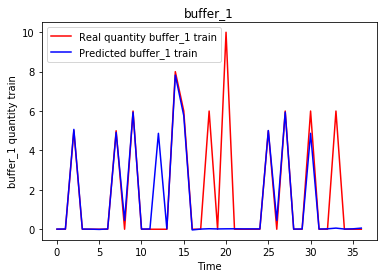

In [18]:
y_train_predict_buffer_1 = regressor.predict(X_train_buffer_1)

# Visualising the results for training set
plt.plot(y_train_buffer_1, color = 'red', label = 'Real quantity buffer_1 train')
plt.plot(y_train_predict_buffer_1, color = 'blue', label = 'Predicted buffer_1 train')
plt.title('buffer_1')
plt.xlabel('Time')
plt.ylabel('buffer_1 quantity train')
plt.legend()
plt.show()

In [19]:
# mean_absolute_error for training set
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train_buffer_1, y_train_predict_buffer_1)

0.8065913574317017

## Making the predictions and visualising the results

In [20]:
# Getting the predicted quantity for buffer_1
X_test_buffer_1 = []
for i in range(42, 49):
    X_test_buffer_1.append(total_set[i-5:i, 1])
X_test_buffer_1 = np.array(X_test_buffer_1)
X_test_buffer_1 = np.reshape(X_test_buffer_1, (X_test_buffer_1.shape[0], X_test_buffer_1.shape[1], 1))

In [21]:
# prediction
predicted_buffer_1 = regressor.predict(X_test_buffer_1)

In [22]:
y_test_buffer_1 = buffer_1['quantity'].values
y_test_buffer_1 = y_test_buffer_1[42:50]

## visualise test set

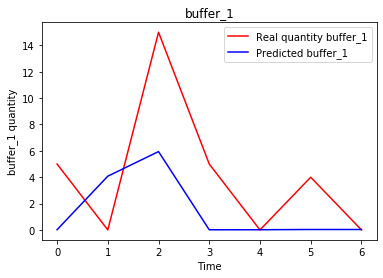

In [23]:
# Visualising the results
plt.plot(y_test_buffer_1, color = 'red', label = 'Real quantity buffer_1')
plt.plot(predicted_buffer_1, color = 'blue', label = 'Predicted buffer_1')
plt.title('buffer_1')
plt.xlabel('Time')
plt.ylabel('buffer_1 quantity')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error
print('mean_absolute_error')
mean_absolute_error(y_test_buffer_1, predicted_buffer_1)

# from sklearn.metrics import accuracy_score
# print('accuracy_score')
# accuracy_score(y_test_buffer_1, predicted_buffer_1)

mean_absolute_error


3.8745305804269656

## run the same for buffer_2 

Epoch 1/2000
37/37 [==============================] - 2s 51ms/step - loss: 2.0340
Epoch 2/2000
37/37 [==============================] - 0s 673us/step - loss: 2.0384
Epoch 3/2000
37/37 [==============================] - 0s 593us/step - loss: 2.0398
Epoch 4/2000
37/37 [==============================] - 0s 566us/step - loss: 2.0392
Epoch 5/2000
37/37 [==============================] - 0s 674us/step - loss: 2.0282
Epoch 6/2000
37/37 [==============================] - 0s 836us/step - loss: 2.0370
Epoch 7/2000
37/37 [==============================] - 0s 620us/step - loss: 2.0376
Epoch 8/2000
37/37 [==============================] - ETA: 0s - loss: 2.034 - 0s 674us/step - loss: 2.0305
Epoch 9/2000
37/37 [==============================] - 0s 593us/step - loss: 2.0313
Epoch 10/2000
37/37 [==============================] - 0s 620us/step - loss: 2.0352
Epoch 11/2000
37/37 [==============================] - 0s 701us/step - loss: 2.0361
Epoch 12/2000
37/37 [==============================] - 0s 755u

37/37 [==============================] - 0s 512us/step - loss: 1.6635
Epoch 195/2000
37/37 [==============================] - 0s 485us/step - loss: 1.6094
Epoch 196/2000
37/37 [==============================] - 0s 485us/step - loss: 1.7036
Epoch 197/2000
37/37 [==============================] - 0s 539us/step - loss: 1.7171
Epoch 198/2000
37/37 [==============================] - 0s 512us/step - loss: 1.7590
Epoch 199/2000
37/37 [==============================] - 0s 512us/step - loss: 1.6874
Epoch 200/2000
37/37 [==============================] - 0s 485us/step - loss: 1.6133
Epoch 201/2000
37/37 [==============================] - 0s 539us/step - loss: 1.6021
Epoch 202/2000
37/37 [==============================] - 0s 512us/step - loss: 1.7163
Epoch 203/2000
37/37 [==============================] - 0s 539us/step - loss: 1.6722
Epoch 204/2000
37/37 [==============================] - 0s 485us/step - loss: 1.6441
Epoch 205/2000
37/37 [==============================] - 0s 512us/step - loss: 1.

37/37 [==============================] - 0s 485us/step - loss: 1.4781
Epoch 387/2000
37/37 [==============================] - 0s 485us/step - loss: 1.4735
Epoch 388/2000
37/37 [==============================] - 0s 485us/step - loss: 1.4997
Epoch 389/2000
37/37 [==============================] - 0s 485us/step - loss: 1.5501
Epoch 390/2000
37/37 [==============================] - 0s 485us/step - loss: 1.5011
Epoch 391/2000
37/37 [==============================] - 0s 485us/step - loss: 1.5167
Epoch 392/2000
37/37 [==============================] - 0s 485us/step - loss: 1.5208
Epoch 393/2000
37/37 [==============================] - 0s 512us/step - loss: 1.4280
Epoch 394/2000
37/37 [==============================] - 0s 566us/step - loss: 1.5061
Epoch 395/2000
37/37 [==============================] - 0s 485us/step - loss: 1.5412
Epoch 396/2000
37/37 [==============================] - 0s 485us/step - loss: 1.4701
Epoch 397/2000
37/37 [==============================] - 0s 485us/step - loss: 1.

Epoch 578/2000
37/37 [==============================] - 0s 674us/step - loss: 1.4012
Epoch 579/2000
37/37 [==============================] - 0s 647us/step - loss: 1.4173
Epoch 580/2000
37/37 [==============================] - 0s 674us/step - loss: 1.4419
Epoch 581/2000
37/37 [==============================] - 0s 674us/step - loss: 1.3651
Epoch 582/2000
37/37 [==============================] - 0s 647us/step - loss: 1.4610
Epoch 583/2000
37/37 [==============================] - 0s 728us/step - loss: 1.3987
Epoch 584/2000
37/37 [==============================] - 0s 767us/step - loss: 1.4311
Epoch 585/2000
37/37 [==============================] - 0s 674us/step - loss: 1.4478
Epoch 586/2000
37/37 [==============================] - 0s 701us/step - loss: 1.3786
Epoch 587/2000
37/37 [==============================] - 0s 701us/step - loss: 1.4149
Epoch 588/2000
37/37 [==============================] - 0s 674us/step - loss: 1.4114
Epoch 589/2000
37/37 [==============================] - 0s 701us/

37/37 [==============================] - 0s 782us/step - loss: 1.4571
Epoch 771/2000
37/37 [==============================] - 0s 755us/step - loss: 1.4013
Epoch 772/2000
37/37 [==============================] - 0s 674us/step - loss: 1.3667
Epoch 773/2000
37/37 [==============================] - 0s 674us/step - loss: 1.3720
Epoch 774/2000
37/37 [==============================] - 0s 728us/step - loss: 1.3104
Epoch 775/2000
37/37 [==============================] - 0s 728us/step - loss: 1.4001
Epoch 776/2000
37/37 [==============================] - 0s 674us/step - loss: 1.3593
Epoch 777/2000
37/37 [==============================] - 0s 728us/step - loss: 1.3546
Epoch 778/2000
37/37 [==============================] - 0s 701us/step - loss: 1.3443
Epoch 779/2000
37/37 [==============================] - 0s 728us/step - loss: 1.3627
Epoch 780/2000
37/37 [==============================] - 0s 701us/step - loss: 1.3693
Epoch 781/2000
37/37 [==============================] - 0s 701us/step - loss: 1.

37/37 [==============================] - 0s 674us/step - loss: 1.3192
Epoch 963/2000
37/37 [==============================] - 0s 674us/step - loss: 1.2933
Epoch 964/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.3096
Epoch 965/2000
37/37 [==============================] - 0s 755us/step - loss: 1.4027
Epoch 966/2000
37/37 [==============================] - 0s 701us/step - loss: 1.3090
Epoch 967/2000
37/37 [==============================] - 0s 674us/step - loss: 1.3769
Epoch 968/2000
37/37 [==============================] - 0s 674us/step - loss: 1.3406
Epoch 969/2000
37/37 [==============================] - 0s 647us/step - loss: 1.3346
Epoch 970/2000
37/37 [==============================] - 0s 701us/step - loss: 1.3970
Epoch 971/2000
37/37 [==============================] - 0s 701us/step - loss: 1.3485
Epoch 972/2000
37/37 [==============================] - 0s 728us/step - loss: 1.3574
Epoch 973/2000
37/37 [==============================] - 0s 674us/step - loss: 1.35

Epoch 1058/2000
37/37 [==============================] - 0s 755us/step - loss: 1.3202
Epoch 1059/2000
37/37 [==============================] - 0s 809us/step - loss: 1.2865
Epoch 1060/2000
37/37 [==============================] - 0s 796us/step - loss: 1.2753
Epoch 1061/2000
37/37 [==============================] - 0s 809us/step - loss: 1.2816
Epoch 1062/2000
37/37 [==============================] - 0s 836us/step - loss: 1.2838
Epoch 1063/2000
37/37 [==============================] - 0s 997us/step - loss: 1.2782
Epoch 1064/2000
37/37 [==============================] - 0s 728us/step - loss: 1.3756
Epoch 1065/2000
37/37 [==============================] - 0s 782us/step - loss: 1.2611
Epoch 1066/2000
37/37 [==============================] - 0s 836us/step - loss: 1.3204
Epoch 1067/2000
37/37 [==============================] - 0s 755us/step - loss: 1.3171
Epoch 1068/2000
37/37 [==============================] - 0s 701us/step - loss: 1.2836
Epoch 1069/2000
37/37 [==============================]

37/37 [==============================] - 0s 701us/step - loss: 1.2211
Epoch 1249/2000
37/37 [==============================] - 0s 755us/step - loss: 1.0925
Epoch 1250/2000
37/37 [==============================] - 0s 674us/step - loss: 1.1688
Epoch 1251/2000
37/37 [==============================] - 0s 728us/step - loss: 1.1687
Epoch 1252/2000
37/37 [==============================] - 0s 755us/step - loss: 1.1966
Epoch 1253/2000
37/37 [==============================] - 0s 755us/step - loss: 1.1047
Epoch 1254/2000
37/37 [==============================] - 0s 701us/step - loss: 1.0691
Epoch 1255/2000
37/37 [==============================] - 0s 674us/step - loss: 1.1336
Epoch 1256/2000
37/37 [==============================] - 0s 701us/step - loss: 1.1472
Epoch 1257/2000
37/37 [==============================] - 0s 701us/step - loss: 1.1190
Epoch 1258/2000
37/37 [==============================] - 0s 674us/step - loss: 1.1973
Epoch 1259/2000
37/37 [==============================] - 0s 728us/step

37/37 [==============================] - 0s 755us/step - loss: 1.0449
Epoch 1439/2000
37/37 [==============================] - 0s 782us/step - loss: 0.9866
Epoch 1440/2000
37/37 [==============================] - 0s 674us/step - loss: 0.9237
Epoch 1441/2000
37/37 [==============================] - 0s 701us/step - loss: 0.9280
Epoch 1442/2000
37/37 [==============================] - 0s 674us/step - loss: 0.9478
Epoch 1443/2000
37/37 [==============================] - 0s 674us/step - loss: 0.9615
Epoch 1444/2000
37/37 [==============================] - 0s 701us/step - loss: 0.9763
Epoch 1445/2000
37/37 [==============================] - 0s 728us/step - loss: 1.0345
Epoch 1446/2000
37/37 [==============================] - 0s 674us/step - loss: 1.0030
Epoch 1447/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9999
Epoch 1448/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9439
Epoch 1449/2000
37/37 [==============================] - 0s 647us/step

37/37 [==============================] - 0s 809us/step - loss: 0.9714
Epoch 1629/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9025
Epoch 1630/2000
37/37 [==============================] - 0s 782us/step - loss: 1.0092
Epoch 1631/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9904
Epoch 1632/2000
37/37 [==============================] - 0s 782us/step - loss: 1.1050
Epoch 1633/2000
37/37 [==============================] - 0s 782us/step - loss: 1.0504
Epoch 1634/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9379
Epoch 1635/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9786
Epoch 1636/2000
37/37 [==============================] - 0s 809us/step - loss: 1.0100
Epoch 1637/2000
37/37 [==============================] - 0s 809us/step - loss: 1.0519
Epoch 1638/2000
37/37 [==============================] - 0s 863us/step - loss: 0.9569
Epoch 1639/2000
37/37 [==============================] - 0s 755us/step

37/37 [==============================] - 0s 755us/step - loss: 0.9322
Epoch 1819/2000
37/37 [==============================] - 0s 728us/step - loss: 0.8982
Epoch 1820/2000
37/37 [==============================] - 0s 728us/step - loss: 0.8458
Epoch 1821/2000
37/37 [==============================] - 0s 782us/step - loss: 0.9329
Epoch 1822/2000
37/37 [==============================] - 0s 701us/step - loss: 1.0313
Epoch 1823/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9041
Epoch 1824/2000
37/37 [==============================] - 0s 755us/step - loss: 0.8509
Epoch 1825/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9234
Epoch 1826/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9714
Epoch 1827/2000
37/37 [==============================] - 0s 755us/step - loss: 0.8561
Epoch 1828/2000
37/37 [==============================] - 0s 863us/step - loss: 1.0220
Epoch 1829/2000
37/37 [==============================] - 0s 836us/step

37/37 [==============================] - 0s 755us/step - loss: 1.0079
Epoch 1914/2000
37/37 [==============================] - 0s 782us/step - loss: 0.8686
Epoch 1915/2000
37/37 [==============================] - 0s 917us/step - loss: 0.9981
Epoch 1916/2000
37/37 [==============================] - 0s 863us/step - loss: 1.0061
Epoch 1917/2000
37/37 [==============================] - 0s 809us/step - loss: 1.0586
Epoch 1918/2000
37/37 [==============================] - 0s 835us/step - loss: 0.9259
Epoch 1919/2000
37/37 [==============================] - 0s 809us/step - loss: 0.8598
Epoch 1920/2000
37/37 [==============================] - 0s 728us/step - loss: 1.0265
Epoch 1921/2000
37/37 [==============================] - 0s 782us/step - loss: 0.8827
Epoch 1922/2000
37/37 [==============================] - 0s 782us/step - loss: 0.8920
Epoch 1923/2000
37/37 [==============================] - 0s 755us/step - loss: 0.8402
Epoch 1924/2000
37/37 [==============================] - 0s 782us/step

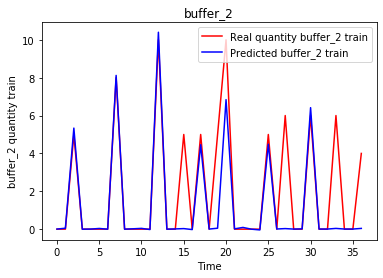

0.8571135200358726

In [25]:
# buffer_2

# Creating a data structure with 5 timesteps and 1 output
X_train_buffer_2 = []
y_train_buffer_2 = []
for i in range(5, 42):
    X_train_buffer_2.append(training_set[i-5:i, 2])
    y_train_buffer_2.append(training_set[i, 2])
X_train_buffer_2, y_train_buffer_2 = np.array(X_train_buffer_2), np.array(y_train_buffer_2)

# Reshaping
X_train_buffer_2 = np.reshape(X_train_buffer_2, (X_train_buffer_2.shape[0], X_train_buffer_2.shape[1], 1))

# Initialising the RNN
regressor2 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_buffer_2.shape[1], 1)))
regressor2.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor2.add(LSTM(units = 50, return_sequences = True))
regressor2.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor2.add(LSTM(units = 50))
regressor2.add(Dropout(0.2))

# Adding the output layer
regressor2.add(Dense(units = 1))

# Compiling the RNN
regressor2.compile(optimizer = 'adam', loss = 'mean_absolute_error')

# Fitting the RNN to the Training set
regressor2.fit(X_train_buffer_2, y_train_buffer_2, epochs = my_epochs, batch_size = my_batch_size)

y_train_predict_buffer_2 = regressor2.predict(X_train_buffer_2)

# Visualising the results for training set
plt.plot(y_train_buffer_2, color = 'red', label = 'Real quantity buffer_2 train')
plt.plot(y_train_predict_buffer_2, color = 'blue', label = 'Predicted buffer_2 train')
plt.title('buffer_2')
plt.xlabel('Time')
plt.ylabel('buffer_2 quantity train')
plt.legend()
plt.show()

# metric for training set
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train_buffer_2, y_train_predict_buffer_2)

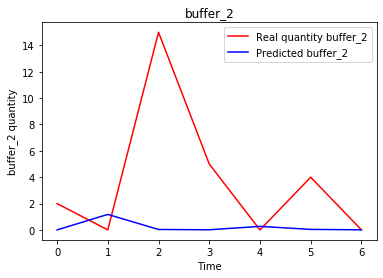

3.9097587104354585

In [26]:
# fit to test data buffer_2

# Getting the predicted quantity for buffer_2
X_test_buffer_2 = []
for i in range(42, 49):
    X_test_buffer_2.append(total_set[i-5:i, 2])
X_test_buffer_2 = np.array(X_test_buffer_2)
X_test_buffer_2 = np.reshape(X_test_buffer_2, (X_test_buffer_2.shape[0], X_test_buffer_2.shape[1], 1))

# prediction
predicted_buffer_2 = regressor2.predict(X_test_buffer_2)

y_test_buffer_2 = buffer_2['quantity'].values
y_test_buffer_2 = y_test_buffer_2[42:50]

# Visualising the results
plt.plot(y_test_buffer_2, color = 'red', label = 'Real quantity buffer_2')
plt.plot(predicted_buffer_2, color = 'blue', label = 'Predicted buffer_2')
plt.title('buffer_2')
plt.xlabel('Time')
plt.ylabel('buffer_2 quantity')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_buffer_2, predicted_buffer_2)


## run the same for buffer_3

Epoch 1/2000
37/37 [==============================] - 2s 56ms/step - loss: 2.0505
Epoch 2/2000
37/37 [==============================] - 0s 592us/step - loss: 2.0357
Epoch 3/2000
37/37 [==============================] - 0s 620us/step - loss: 2.0390
Epoch 4/2000
37/37 [==============================] - 0s 620us/step - loss: 2.0371
Epoch 5/2000
37/37 [==============================] - 0s 620us/step - loss: 2.0357
Epoch 6/2000
37/37 [==============================] - 0s 539us/step - loss: 2.0318
Epoch 7/2000
37/37 [==============================] - 0s 620us/step - loss: 2.0335
Epoch 8/2000
37/37 [==============================] - 0s 593us/step - loss: 2.0334
Epoch 9/2000
37/37 [==============================] - 0s 620us/step - loss: 2.0320
Epoch 10/2000
37/37 [==============================] - 0s 593us/step - loss: 2.0312
Epoch 11/2000
37/37 [==============================] - 0s 566us/step - loss: 2.0290
Epoch 12/2000
37/37 [==============================] - 0s 674us/step - loss: 2.0322
Ep

37/37 [==============================] - 0s 620us/step - loss: 1.7328
Epoch 195/2000
37/37 [==============================] - 0s 620us/step - loss: 1.7354
Epoch 196/2000
37/37 [==============================] - 0s 647us/step - loss: 1.7301
Epoch 197/2000
37/37 [==============================] - 0s 620us/step - loss: 1.7679
Epoch 198/2000
37/37 [==============================] - 0s 593us/step - loss: 1.6908
Epoch 199/2000
37/37 [==============================] - 0s 620us/step - loss: 1.6830
Epoch 200/2000
37/37 [==============================] - 0s 593us/step - loss: 1.6777
Epoch 201/2000
37/37 [==============================] - 0s 593us/step - loss: 1.6992
Epoch 202/2000
37/37 [==============================] - 0s 647us/step - loss: 1.6379
Epoch 203/2000
37/37 [==============================] - 0s 620us/step - loss: 1.6563
Epoch 204/2000
37/37 [==============================] - 0s 620us/step - loss: 1.7489
Epoch 205/2000
37/37 [==============================] - 0s 620us/step - loss: 1.

37/37 [==============================] - 0s 593us/step - loss: 1.4586
Epoch 387/2000
37/37 [==============================] - 0s 512us/step - loss: 1.4695
Epoch 388/2000
37/37 [==============================] - 0s 512us/step - loss: 1.4818
Epoch 389/2000
37/37 [==============================] - 0s 512us/step - loss: 1.5102
Epoch 390/2000
37/37 [==============================] - 0s 539us/step - loss: 1.6367
Epoch 391/2000
37/37 [==============================] - 0s 674us/step - loss: 1.6652
Epoch 392/2000
37/37 [==============================] - 0s 512us/step - loss: 1.6056
Epoch 393/2000
37/37 [==============================] - 0s 539us/step - loss: 1.6119
Epoch 394/2000
37/37 [==============================] - 0s 539us/step - loss: 1.5850
Epoch 395/2000
37/37 [==============================] - 0s 566us/step - loss: 1.5667
Epoch 396/2000
37/37 [==============================] - 0s 539us/step - loss: 1.5753
Epoch 397/2000
37/37 [==============================] - 0s 539us/step - loss: 1.

37/37 [==============================] - 0s 863us/step - loss: 1.4206
Epoch 579/2000
37/37 [==============================] - 0s 782us/step - loss: 1.3869
Epoch 580/2000
37/37 [==============================] - 0s 836us/step - loss: 1.4421
Epoch 581/2000
37/37 [==============================] - 0s 782us/step - loss: 1.3766
Epoch 582/2000
37/37 [==============================] - 0s 836us/step - loss: 1.4446
Epoch 583/2000
37/37 [==============================] - 0s 836us/step - loss: 1.4287
Epoch 584/2000
37/37 [==============================] - 0s 970us/step - loss: 1.4498
Epoch 585/2000
37/37 [==============================] - 0s 970us/step - loss: 1.3983
Epoch 586/2000
37/37 [==============================] - 0s 916us/step - loss: 1.4502
Epoch 587/2000
37/37 [==============================] - 0s 809us/step - loss: 1.3905
Epoch 588/2000
37/37 [==============================] - 0s 916us/step - loss: 1.3965
Epoch 589/2000
37/37 [==============================] - 0s 835us/step - loss: 1.

37/37 [==============================] - 0s 674us/step - loss: 1.2313
Epoch 771/2000
37/37 [==============================] - 0s 647us/step - loss: 1.2513
Epoch 772/2000
37/37 [==============================] - 0s 647us/step - loss: 1.2315
Epoch 773/2000
37/37 [==============================] - 0s 674us/step - loss: 1.1954
Epoch 774/2000
37/37 [==============================] - 0s 647us/step - loss: 1.1391
Epoch 775/2000
37/37 [==============================] - 0s 647us/step - loss: 1.1802
Epoch 776/2000
37/37 [==============================] - 0s 647us/step - loss: 1.1961
Epoch 777/2000
37/37 [==============================] - 0s 647us/step - loss: 1.2164
Epoch 778/2000
37/37 [==============================] - 0s 674us/step - loss: 1.2947
Epoch 779/2000
37/37 [==============================] - 0s 755us/step - loss: 1.2788
Epoch 780/2000
37/37 [==============================] - 0s 647us/step - loss: 1.2379
Epoch 781/2000
37/37 [==============================] - 0s 701us/step - loss: 1.

37/37 [==============================] - 0s 647us/step - loss: 0.9079
Epoch 963/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9927
Epoch 964/2000
37/37 [==============================] - 0s 701us/step - loss: 0.9287
Epoch 965/2000
37/37 [==============================] - 0s 647us/step - loss: 1.0110
Epoch 966/2000
37/37 [==============================] - 0s 647us/step - loss: 1.0123
Epoch 967/2000
37/37 [==============================] - 0s 674us/step - loss: 1.0334
Epoch 968/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9623
Epoch 969/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9744
Epoch 970/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9953
Epoch 971/2000
37/37 [==============================] - 0s 1ms/step - loss: 1.0357
Epoch 972/2000
37/37 [==============================] - 0s 1ms/step - loss: 0.9576
Epoch 973/2000
37/37 [==============================] - 0s 943us/step - loss: 1.0341

Epoch 1058/2000
37/37 [==============================] - 0s 620us/step - loss: 0.9868
Epoch 1059/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9703
Epoch 1060/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9518
Epoch 1061/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9679
Epoch 1062/2000
37/37 [==============================] - 0s 701us/step - loss: 0.8781
Epoch 1063/2000
37/37 [==============================] - 0s 674us/step - loss: 0.9394
Epoch 1064/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9285
Epoch 1065/2000
37/37 [==============================] - 0s 674us/step - loss: 0.9120
Epoch 1066/2000
37/37 [==============================] - 0s 728us/step - loss: 0.9532
Epoch 1067/2000
37/37 [==============================] - 0s 647us/step - loss: 0.9217
Epoch 1068/2000
37/37 [==============================] - 0s 647us/step - loss: 1.0206
Epoch 1069/2000
37/37 [==============================]

37/37 [==============================] - 0s 674us/step - loss: 1.0041
Epoch 1154/2000
37/37 [==============================] - 0s 782us/step - loss: 0.9782
Epoch 1155/2000
37/37 [==============================] - 0s 728us/step - loss: 0.8797
Epoch 1156/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9858
Epoch 1157/2000
37/37 [==============================] - 0s 701us/step - loss: 0.9952
Epoch 1158/2000
37/37 [==============================] - 0s 782us/step - loss: 0.9190
Epoch 1159/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9442
Epoch 1160/2000
37/37 [==============================] - 0s 728us/step - loss: 0.9042
Epoch 1161/2000
37/37 [==============================] - 0s 674us/step - loss: 0.9952
Epoch 1162/2000
37/37 [==============================] - 0s 674us/step - loss: 0.9415
Epoch 1163/2000
37/37 [==============================] - 0s 647us/step - loss: 0.8923
Epoch 1164/2000
37/37 [==============================] - 0s 674us/step

37/37 [==============================] - 0s 836us/step - loss: 0.9620
Epoch 1249/2000
37/37 [==============================] - 0s 836us/step - loss: 0.8408
Epoch 1250/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9637
Epoch 1251/2000
37/37 [==============================] - 0s 890us/step - loss: 0.8709
Epoch 1252/2000
37/37 [==============================] - 0s 998us/step - loss: 0.9476
Epoch 1253/2000
37/37 [==============================] - 0s 943us/step - loss: 0.8969
Epoch 1254/2000
37/37 [==============================] - 0s 890us/step - loss: 0.9364
Epoch 1255/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9777
Epoch 1256/2000
37/37 [==============================] - 0s 863us/step - loss: 0.9938
Epoch 1257/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9207
Epoch 1258/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9725
Epoch 1259/2000
37/37 [==============================] - 0s 836us/step

Epoch 1343/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9115
Epoch 1344/2000
37/37 [==============================] - 0s 863us/step - loss: 0.9118
Epoch 1345/2000
37/37 [==============================] - 0s 836us/step - loss: 0.8891
Epoch 1346/2000
37/37 [==============================] - 0s 836us/step - loss: 0.9024
Epoch 1347/2000
37/37 [==============================] - 0s 782us/step - loss: 0.8909
Epoch 1348/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9086
Epoch 1349/2000
37/37 [==============================] - 0s 728us/step - loss: 0.9675
Epoch 1350/2000
37/37 [==============================] - 0s 782us/step - loss: 0.9457
Epoch 1351/2000
37/37 [==============================] - 0s 782us/step - loss: 0.8320
Epoch 1352/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9031
Epoch 1353/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9248
Epoch 1354/2000
37/37 [==============================]

37/37 [==============================] - 0s 755us/step - loss: 0.9097
Epoch 1533/2000
37/37 [==============================] - 0s 728us/step - loss: 0.8839
Epoch 1534/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9286
Epoch 1535/2000
37/37 [==============================] - 0s 808us/step - loss: 0.8988
Epoch 1536/2000
37/37 [==============================] - 0s 916us/step - loss: 0.8691
Epoch 1537/2000
37/37 [==============================] - 0s 890us/step - loss: 0.8924
Epoch 1538/2000
37/37 [==============================] - 0s 728us/step - loss: 0.9079
Epoch 1539/2000
37/37 [==============================] - 0s 755us/step - loss: 0.8936
Epoch 1540/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9201
Epoch 1541/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9971
Epoch 1542/2000
37/37 [==============================] - 0s 755us/step - loss: 0.9462
Epoch 1543/2000
37/37 [==============================] - 0s 782us/step

37/37 [==============================] - 0s 916us/step - loss: 0.8691
Epoch 1723/2000
37/37 [==============================] - 0s 836us/step - loss: 0.8303
Epoch 1724/2000
37/37 [==============================] - 0s 809us/step - loss: 0.9090
Epoch 1725/2000
37/37 [==============================] - 0s 836us/step - loss: 0.8851
Epoch 1726/2000
37/37 [==============================] - 0s 782us/step - loss: 0.7698
Epoch 1727/2000
37/37 [==============================] - 0s 836us/step - loss: 0.8319
Epoch 1728/2000
37/37 [==============================] - 0s 863us/step - loss: 0.8581
Epoch 1729/2000
37/37 [==============================] - 0s 944us/step - loss: 0.8307
Epoch 1730/2000
37/37 [==============================] - 0s 943us/step - loss: 0.9666
Epoch 1731/2000
37/37 [==============================] - 0s 943us/step - loss: 0.8936
Epoch 1732/2000
37/37 [==============================] - 0s 862us/step - loss: 0.8164
Epoch 1733/2000
37/37 [==============================] - 0s 863us/step

37/37 [==============================] - 0s 863us/step - loss: 0.8114
Epoch 1913/2000
37/37 [==============================] - 0s 916us/step - loss: 0.8486
Epoch 1914/2000
37/37 [==============================] - 0s 997us/step - loss: 0.9262
Epoch 1915/2000
37/37 [==============================] - 0s 1ms/step - loss: 0.8404
Epoch 1916/2000
37/37 [==============================] - 0s 1ms/step - loss: 0.8593
Epoch 1917/2000
37/37 [==============================] - 0s 1ms/step - loss: 0.8628
Epoch 1918/2000
37/37 [==============================] - 0s 1ms/step - loss: 0.8173
Epoch 1919/2000
37/37 [==============================] - 0s 1ms/step - loss: 0.9308
Epoch 1920/2000
37/37 [==============================] - 0s 1ms/step - loss: 0.8982
Epoch 1921/2000
37/37 [==============================] - 0s 943us/step - loss: 0.8469
Epoch 1922/2000
37/37 [==============================] - 0s 997us/step - loss: 0.8868
Epoch 1923/2000
37/37 [==============================] - 0s 943us/step - loss: 0.8

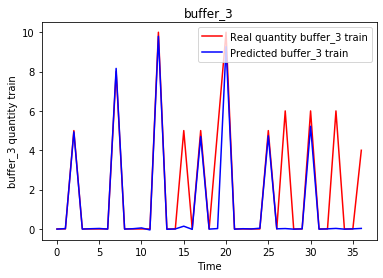

0.7742496912141104

In [27]:
# buffer_3

# Creating a data structure with 5 timesteps and 1 output
X_train_buffer_3 = []
y_train_buffer_3 = []
for i in range(5, 42):
    X_train_buffer_3.append(training_set[i-5:i, 2])
    y_train_buffer_3.append(training_set[i, 2])
X_train_buffer_3, y_train_buffer_3 = np.array(X_train_buffer_3), np.array(y_train_buffer_3)

# Reshaping
X_train_buffer_3 = np.reshape(X_train_buffer_3, (X_train_buffer_3.shape[0], X_train_buffer_3.shape[1], 1))

# Initialising the RNN
regressor3 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor3.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_buffer_3.shape[1], 1)))
regressor3.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor3.add(LSTM(units = 50, return_sequences = True))
regressor3.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor3.add(LSTM(units = 50))
regressor3.add(Dropout(0.2))

# Adding the output layer
regressor3.add(Dense(units = 1))

# Compiling the RNN
regressor3.compile(optimizer = 'adam', loss = 'mean_absolute_error')

# Fitting the RNN to the Training set
regressor3.fit(X_train_buffer_3, y_train_buffer_3, epochs = my_epochs, batch_size = my_batch_size)

y_train_predict_buffer_3 = regressor3.predict(X_train_buffer_3)

# Visualising the results for training set
plt.plot(y_train_buffer_3, color = 'red', label = 'Real quantity buffer_3 train')
plt.plot(y_train_predict_buffer_3, color = 'blue', label = 'Predicted buffer_3 train')
plt.title('buffer_3')
plt.xlabel('Time')
plt.ylabel('buffer_3 quantity train')
plt.legend()
plt.show()

# metric for training set
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train_buffer_3, y_train_predict_buffer_3)

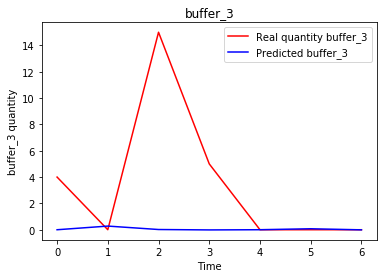

3.4798627282891954

In [28]:
# fit to test data buffer_3

# Getting the predicted quantity for buffer_3
X_test_buffer_3 = []
for i in range(42, 49):
    X_test_buffer_3.append(total_set[i-5:i, 2])
X_test_buffer_3 = np.array(X_test_buffer_3)
X_test_buffer_3 = np.reshape(X_test_buffer_3, (X_test_buffer_3.shape[0], X_test_buffer_3.shape[1], 1))

# prediction
predicted_buffer_3 = regressor3.predict(X_test_buffer_3)

y_test_buffer_3 = buffer_3['quantity'].values
y_test_buffer_3 = y_test_buffer_3[42:50]

# Visualising the results
plt.plot(y_test_buffer_3, color = 'red', label = 'Real quantity buffer_3')
plt.plot(predicted_buffer_3, color = 'blue', label = 'Predicted buffer_3')
plt.title('buffer_3')
plt.xlabel('Time')
plt.ylabel('buffer_3 quantity')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_buffer_3, predicted_buffer_3)